# Experimental study of nonclassical teleportation beyond average fidelity

## Ideal case analysis:

In this section we are going to check the calculations already presented in the paper for correctness

Input states:

In [1]:
psix = zeros(2,2,6);

psix(:,:,1) = 1/2*(eye(2) + Pauli(1));
psix(:,:,2) = 1/2*(eye(2) - Pauli(1));
psix(:,:,3) = 1/2*(eye(2) + Pauli(2));
psix(:,:,4) = 1/2*(eye(2) - Pauli(2));
psix(:,:,5) = 1/2*(eye(2) + Pauli(3));
psix(:,:,6) = 1/2*(eye(2) - Pauli(3));

Shared state:

In [30]:
psim = [0 1 -1 0]'/sqrt(2);
psip = [0 1 1 0]'/sqrt(2);

psi11 = [0 0 0 1]';

gamma = 0.9;
rho = gamma*psim*psim' + (1-gamma)*psi11*psi11';

Measurement:

In [20]:
Ma = zeros(4,4,2);
Ma(:,:,1) = psim*psim';
Ma(:,:,2) = eye(4) - Ma(:,:,1);

Generate teleportation data:

In [21]:
sigma = genTeleportationData(rho,Ma,psix);
sigx = squeeze(sigma(:,:,1,:));

In [22]:
paulidecomp = zeros(6,4);

for x = 1:6
    paulidecomp(x,:) = [trace(sigx(:,:,x)) [trace(sigx(:,:,x)*Pauli(1)) trace(sigx(:,:,x)*Pauli(2)) trace(sigx(:,:,x)*Pauli(3))]/trace(sigx(:,:,x))];
    
end

paulidecomp

paulidecomp =
    0.2500    0.9000         0   -0.1000
    0.2500   -0.9000         0   -0.1000
    0.2500         0    0.9000   -0.1000
    0.2500         0   -0.9000   -0.1000
    0.2750         0         0    0.6364
    0.2250         0         0   -1.0000


Witness:

In [31]:
theta = atan(gamma/(1-gamma));

Fax = zeros(2,2,6);
Fax(:,:,1) = -2*sin(theta)*Pauli(1);
Fax(:,:,2) = +2*sin(theta)*Pauli(1);
Fax(:,:,3) = -2*sin(theta)*Pauli(2);
Fax(:,:,4) = +2*sin(theta)*Pauli(2);
Fax(:,:,5) = 2*(1-cos(theta))*(eye(2) - Pauli(3));
Fax(:,:,6) = 2*(1+cos(theta))*(eye(2) + Pauli(3));

Witness value:

In [26]:
beta = 0;
for x = 1:6
    beta = beta + trace(Fax(:,:,x)*sigx(:,:,x));
end

beta

beta =
   -1.6111


Check this value:  
It should be $-2\gamma\sin \theta + 2(1-\gamma)(1-\cos\theta)$

In [32]:
-2*gamma*sin(theta) + 2*(1-gamma)*(1-cos(theta))

ans =
   -1.6111


$M^{VB}_0$ calculation:

In [19]:
M = zeros(4,4);
for x = 1:6
    M = M + Tensor(psix(:,:,x),Fax(:,:,x));
end

[V,D] = eig(M)

V =
         0    1.0000         0         0
   -0.7451         0         0    0.6669
    0.6669         0         0    0.7451
         0         0    1.0000         0
D =
   -0.0000         0         0         0
         0         0         0         0
         0         0         0         0
         0         0         0    8.0000


#### Conclusion:

The conclusion from the above is that for the ideal analysis, everything is indeed correct.

## Experimental case analysis:

Shared state:

NOTE: Here we are correcting the typo $\nu \to \nu^2$ from the paper

In [83]:
rhoexp = @(v,gamma,delta) 1/4*[(1-v^2)*gamma,0,0,0;0,2-gamma+v^2*(-2+3*gamma),-2*(1-2*delta)^2*v^2*gamma,...
                                0;0,-2*(1-2*delta)^2*v^2*gamma,(1+v^2)*gamma,0;0,0,0,2+v^2*(2-3*gamma)-gamma];

Experimentally obtained values for $\nu$ and $\delta$:

In [84]:
v = 0.962;
delta = 0.872;

Generate teleportation data, fixing a value for $\gamma$:

In [85]:
gamma = 0.9;

sigmaexp = genTeleportationData(rhoexp(v,gamma,delta),Ma,psix);
sigxexp = squeeze(sigmaexp(:,:,1,:));

Fix the teleportation witness, using the optimal value for $\theta$:

In [77]:
theta = atan(2*(1-2*delta)^2*v^2*gamma/(1+v^2)/(1-gamma));

Fax = zeros(2,2,6);
Fax(:,:,1) = -2*sin(theta)*Pauli(1);
Fax(:,:,2) = +2*sin(theta)*Pauli(1);
Fax(:,:,3) = -2*sin(theta)*Pauli(2);
Fax(:,:,4) = +2*sin(theta)*Pauli(2);
Fax(:,:,5) = 2*(1-cos(theta))*(eye(2) - Pauli(3));
Fax(:,:,6) = 2*(1+cos(theta))*(eye(2) + Pauli(3));

Witness value:

In [81]:
beta = 0;
for x = 1:6
    beta = beta + trace(Fax(:,:,x)*sigxexp(:,:,x));
end

beta

beta =
   -0.6823


Check that this is equal to $1+v^2-2\gamma v^2-(1-\gamma)(1+v^2)\cos(\theta) - 2\gamma(1-2\delta)^2v^2\sin(\theta)$

In [80]:
1+v^2-2*gamma*v^2-(1-gamma)*(1+v^2)*cos(theta) - 2*gamma*(1-2*delta)^2*v^2*sin(theta)

ans =
   -0.6823


#### Conclusion:

Once again, we conclude that everything is ok once the typo was taken care of.

### Teleportation based estimation of entanglement based on witness violation

The goal in this section is to add a new result to the paper: Estimation of negativity using the witness violation.

In [165]:
%%file teleportationNegativityWitness.m

function TNW = teleportationNegativityWitness(Fax,betaobs,omegax)

[dB,~,oa,ma] = size(Fax); % dim. of B, no. of outcomes of Ma, number of 
                            % input states for Alice
[dV,~,~] = size(omegax); % dimension of input states

cvx_begin sdp quiet

    variable Map(dV*dB,dV*dB,oa) hermitian semidefinite% M_a^VB
    variable Mam(dV*dB,dV*dB,oa) hermitian semidefinite % N_a^VB
    variable rhoBp(dB,dB) hermitian %semidefinite
    variable rhoBm(dB,dB) hermitian %semidefinite
    
    expression betavar
    
    minimise trace(rhoBm) 
    
    subject to
    
    
    betavar = 0;
    for x = 1:ma
        for a = 1:oa
            betavar = betavar + trace((Map(:,:,a)-Mam(:,:,a))*...
                Tensor(omegax(:,:,x),Fax(:,:,a,x)));
        end
    end
    
    betavar == betaobs
    
    sum(Map,3) == Tensor(eye(dV),rhoBp)
    sum(Mam,3) == Tensor(eye(dV),rhoBm)
    % sum_a Ma+/- = Id otimes rhoB (no-signalling)
    
cvx_end

TNW = cvx_optval;

end


Created file '/home/phyps/Dropbox/Shared Folders/Steering and teleportation/experimentalists/teleportationNegativityWitness.m'.


### Ideal case

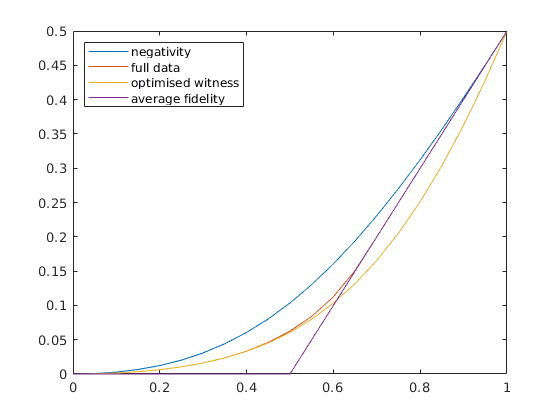

In [223]:
clear

% states to be teleported:

ma = 6;
omegax = zeros(2,2,ma);

omegax(:,:,1) = 1/2*(eye(2) + Pauli(1));
omegax(:,:,2) = 1/2*(eye(2) - Pauli(1));
omegax(:,:,3) = 1/2*(eye(2) + Pauli(2));
omegax(:,:,4) = 1/2*(eye(2) - Pauli(2));
omegax(:,:,5) = 1/2*(eye(2) + Pauli(3));
omegax(:,:,6) = 1/2*(eye(2) - Pauli(3));

% shared state definitions:

psim = [0 1 -1 0]'/sqrt(2);
psip = [0 1 1 0]'/sqrt(2);
psi11 = [0 0 0 1]';

% joint measurements:

Ma = zeros(4,4,2);
Ma(:,:,1) = psim*psim';
Ma(:,:,2) = eye(4) - Ma(:,:,1);

[~,~,oa,~] = size(Ma);

% Witness operators for average fidelity of teleportation.
% We need beta < 0 when there is teleportation, i.e. 2/3 - f_tel

Gax = zeros(2,2,oa,6);
for x = 1:ma
    Gax(:,:,1,x) = 1/ma*(8/3*eye(2) - 4*omegax(:,:,x));
end

% plot the graph:

npoints = 21;
gammav = linspace(0,1,npoints);
TNWv = zeros(1,npoints);
TNWAFv = zeros(1,npoints);
TNv = zeros(1,npoints);
Nv = zeros(1,npoints);

for i = 1:npoints

    gamma = gammav(i);
    rho = gamma*psim*psim' + (1-gamma)*psi11*psi11';
    Nv(i) = Negativity(rho);

    sigma = genTeleportationData(rho,Ma,omegax);

    theta = atan(gamma/(1-gamma)); % optival value of theta for maximum violation 

    Fax = zeros(2,2,oa,6);
    Fax(:,:,1,1) = -2*sin(theta)*Pauli(1);
    Fax(:,:,1,2) = +2*sin(theta)*Pauli(1);
    Fax(:,:,1,3) = -2*sin(theta)*Pauli(2);
    Fax(:,:,1,4) = +2*sin(theta)*Pauli(2);
    Fax(:,:,1,5) = 2*(1-cos(theta))*(eye(2) - Pauli(3));
    Fax(:,:,1,6) = 2*(1+cos(theta))*(eye(2) + Pauli(3));

    betaobs = 0;
    for x = 1:ma
        for a = 1:oa
            betaobs = betaobs + trace(Fax(:,:,a,x)*sigma(:,:,a,x));
        end
    end
    
    betaobsAF = 0;
    for x = 1:ma
        for a = 1:oa
            betaobsAF = betaobsAF + trace(Gax(:,:,a,x)*sigma(:,:,a,x));
        end
    end
    
    TNWv(i) = teleportationNegativityWitness(Fax,betaobs,omegax);
    TNWAFv(i) = teleportationNegativityWitness(Gax,betaobsAF,omegax);
    TNv(i) = teleportationNegativity(sigma,omegax);
    
end

plot(gammav,Nv,gammav,TNv,gammav,TNWv,gammav,TNWAFv)
legend('negativity','full data','optimised witness','average fidelity','Location','northwest')

There are a couple of things worth noting here:

- Although for a full BSM we proved that the full data (given that we use tomographically complete inputs) will give a tight lower bound to the negativity, this is no longer the case for a partial BSM, as can be seen here for the red curve
- There appears to be a linear lower bound provided by the average fidelity witness, ranging from 0 (at the point where the state doesn't violate the witness) to the actual negativity
- The average fidelity appears to be the optimal witness for a large range of parameters, surprisingly
- There is only a small region where the average fidelity is positive and doesn't provide a better lower bound on the negativity.

### Experimental case:

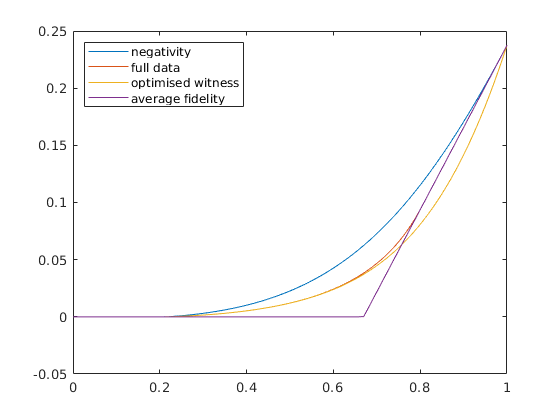

In [224]:
clear

% input states:

ma = 6;
omegax = zeros(2,2,ma);

omegax(:,:,1) = 1/2*(eye(2) + Pauli(1));
omegax(:,:,2) = 1/2*(eye(2) - Pauli(1));
omegax(:,:,3) = 1/2*(eye(2) + Pauli(2));
omegax(:,:,4) = 1/2*(eye(2) - Pauli(2));
omegax(:,:,5) = 1/2*(eye(2) + Pauli(3));
omegax(:,:,6) = 1/2*(eye(2) - Pauli(3));

% experimental shared state

rhoexp = @(v,gamma,delta) 1/4*[(1-v^2)*gamma,0,0,0;0,2-gamma+v^2*(-2+3*gamma),-2*(1-2*delta)^2*v^2*gamma,...
            0;0,-2*(1-2*delta)^2*v^2*gamma,(1+v^2)*gamma,0;0,0,0,2+v^2*(2-3*gamma)-gamma];
                                
v = 0.962;
delta = 0.872;

% joint measurement

psim = [0 1 -1 0]'/sqrt(2);

Ma = zeros(4,4,2);
Ma(:,:,1) = psim*psim';
Ma(:,:,2) = eye(4) - Ma(:,:,1);
[~,~,oa,~] = size(Ma);

% witness operators for average fidelity

Gax = zeros(2,2,oa,6);
for x = 1:ma
    Gax(:,:,1,x) = 1/ma*(8/3*eye(2) - 4*omegax(:,:,x));
end

% plot the graph

npoints = 101;
gammav = linspace(0,1,npoints);
TNWv = zeros(1,npoints);
TNWAFv = zeros(1,npoints);
TNv = zeros(1,npoints);
Nv = zeros(1,npoints);

for i = 1:npoints

    gamma = gammav(i);
    rho = rhoexp(v,gamma,delta);
    Nv(i) = Negativity(rho);

    sigma = genTeleportationData(rho,Ma,omegax);

    theta = atan(2*(1-2*delta)^2*v^2*gamma/(1+v^2)/(1-gamma));

    Fax = zeros(2,2,oa,6);
    Fax(:,:,1,1) = -2*sin(theta)*Pauli(1);
    Fax(:,:,1,2) = +2*sin(theta)*Pauli(1);
    Fax(:,:,1,3) = -2*sin(theta)*Pauli(2);
    Fax(:,:,1,4) = +2*sin(theta)*Pauli(2);
    Fax(:,:,1,5) = 2*(1-cos(theta))*(eye(2) - Pauli(3));
    Fax(:,:,1,6) = 2*(1+cos(theta))*(eye(2) + Pauli(3));

    betaobs = 0;
    for x = 1:ma
        for a = 1:oa
            betaobs = betaobs + trace(Fax(:,:,a,x)*sigma(:,:,a,x));
        end
    end
    
    betaobsAF = 0;
    for x = 1:ma
        for a = 1:oa
            betaobsAF = betaobsAF + trace(Gax(:,:,a,x)*sigma(:,:,a,x));
        end
    end
    
    TNWv(i) = teleportationNegativityWitness(Fax,betaobs,omegax);
    TNWAFv(i) = teleportationNegativityWitness(Gax,betaobsAF,omegax);
    TNv(i) = teleportationNegativity(sigma,omegax);
    
end

plot(gammav,Nv,gammav,TNv,gammav,TNWv,gammav,TNWAFv)
legend('negativity','full data','optimised witness','average fidelity','Location','northwest')

There are a few interesting aspects here once again:
- The average fidelity again appears to be linear, and tight for a range of $\gamma$
- There is again a small region where the witness outperforms average fidelity (when the fidelity is non-zero)

### Check the behaviour of negativity bound as a function of $\theta$ for fixed $\gamma$

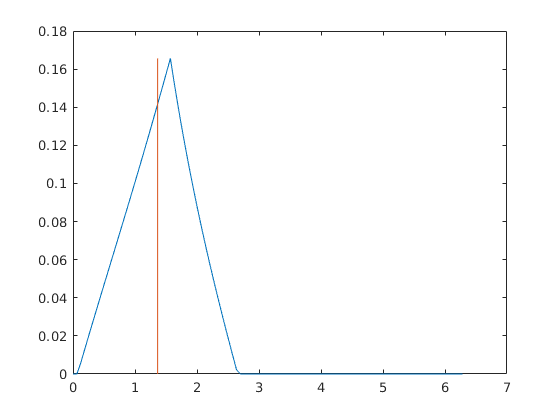

In [234]:
clear

% input states:

ma = 6;
omegax = zeros(2,2,ma);

omegax(:,:,1) = 1/2*(eye(2) + Pauli(1));
omegax(:,:,2) = 1/2*(eye(2) - Pauli(1));
omegax(:,:,3) = 1/2*(eye(2) + Pauli(2));
omegax(:,:,4) = 1/2*(eye(2) - Pauli(2));
omegax(:,:,5) = 1/2*(eye(2) + Pauli(3));
omegax(:,:,6) = 1/2*(eye(2) - Pauli(3));

% experimental state

rhoexp = @(v,gamma,delta) 1/4*[(1-v^2)*gamma,0,0,0;0,2-gamma+v^2*(-2+3*gamma),-2*(1-2*delta)^2*v^2*gamma,...
            0;0,-2*(1-2*delta)^2*v^2*gamma,(1+v^2)*gamma,0;0,0,0,2+v^2*(2-3*gamma)-gamma];

v = 0.962;
delta = 0.872;
gamma = 0.9; % picked arbitrarily

rho = rhoexp(v,gamma,delta);

% old optimal value of theta:

thetaopt = atan(2*(1-2*delta)^2*v^2*gamma/(1+v^2)/(1-gamma));

% joint measurement:

psim = [0 1 -1 0]'/sqrt(2);
Ma = zeros(4,4,2);
Ma(:,:,1) = psim*psim';
Ma(:,:,2) = eye(4) - Ma(:,:,1);
[~,~,oa,~] = size(Ma);

% teleportation assemblage:

sigma = genTeleportationData(rho,Ma,omegax);

% plot the graph:

npoints = 101;
thetav = linspace(0,2*pi,npoints);
TNWv = zeros(1,npoints);

for i = 1:npoints

    theta = thetav(i);

    Fax = zeros(2,2,oa,6);
    Fax(:,:,1,1) = -2*sin(theta)*Pauli(1);
    Fax(:,:,1,2) = +2*sin(theta)*Pauli(1);
    Fax(:,:,1,3) = -2*sin(theta)*Pauli(2);
    Fax(:,:,1,4) = +2*sin(theta)*Pauli(2);
    Fax(:,:,1,5) = 2*(1-cos(theta))*(eye(2) - Pauli(3));
    Fax(:,:,1,6) = 2*(1+cos(theta))*(eye(2) + Pauli(3));

    betaobs = 0;
    for x = 1:ma
        for a = 1:oa
            betaobs = betaobs + trace(Fax(:,:,a,x)*sigma(:,:,a,x));
        end
    end
    
    TNWv(i) = teleportationNegativityWitness(Fax,betaobs,omegax);
    
end



plot(thetav,TNWv,[thetaopt,thetaopt],[0,max(TNWv)])

This graph demonstrates that the optimal value of $\theta$ in terms of largest violation is not the same as the optimal value of $\theta$ for the best estimation of negativity. Thus, we need to obtain the graph of estimated negativity versus $\theta$, for the optimal $\theta$ for this.

### Negativity estimation using the optimal value of $\theta$

In [ ]:
clear

% input states

ma = 6;
omegax = zeros(2,2,ma);

omegax(:,:,1) = 1/2*(eye(2) + Pauli(1));
omegax(:,:,2) = 1/2*(eye(2) - Pauli(1));
omegax(:,:,3) = 1/2*(eye(2) + Pauli(2));
omegax(:,:,4) = 1/2*(eye(2) - Pauli(2));
omegax(:,:,5) = 1/2*(eye(2) + Pauli(3));
omegax(:,:,6) = 1/2*(eye(2) - Pauli(3));

% experimental state

rhoexp = @(v,gamma,delta) 1/4*[(1-v^2)*gamma,0,0,0;0,2-gamma+v^2*(-2+3*gamma),-2*(1-2*delta)^2*v^2*gamma,...
            0;0,-2*(1-2*delta)^2*v^2*gamma,(1+v^2)*gamma,0;0,0,0,2+v^2*(2-3*gamma)-gamma];

v = 0.962;
delta = 0.872;

% joint measurement

psim = [0 1 -1 0]'/sqrt(2);
Ma = zeros(4,4,2);
Ma(:,:,1) = psim*psim';
Ma(:,:,2) = eye(4) - Ma(:,:,1);
[~,~,oa,~] = size(Ma);

% average fidelity witness

Gax = zeros(2,2,oa,6);
for x = 1:ma
    Gax(:,:,1,x) = 1/ma*(8/3*eye(2) - 4*omegax(:,:,x));
end

% obtain the data:

ngam = 101;
npoints = 101;

gammav = linspace(0,1,ngam);
thetav = linspace(0,2*pi,npoints);
TNWv = zeros(ngam,npoints);
TNWOv = zeros(1,ngam);
TNWAFv  = zeros(1,ngam);

for i = 1:ngam

    gamma = gammav(i);
    rho = rhoexp(v,gamma,delta);
    sigma = genTeleportationData(rho,Ma,omegax);

    for j = 1:npoints

        theta = thetav(j);

        Fax = zeros(2,2,oa,6);
        Fax(:,:,1,1) = -2*sin(theta)*Pauli(1);
        Fax(:,:,1,2) = +2*sin(theta)*Pauli(1);
        Fax(:,:,1,3) = -2*sin(theta)*Pauli(2);
        Fax(:,:,1,4) = +2*sin(theta)*Pauli(2);
        Fax(:,:,1,5) = 2*(1-cos(theta))*(eye(2) - Pauli(3));
        Fax(:,:,1,6) = 2*(1+cos(theta))*(eye(2) + Pauli(3));

        betaobs = 0;
        for x = 1:ma
            for a = 1:oa
                betaobs = betaobs + trace(Fax(:,:,a,x)*sigma(:,:,a,x));
            end
        end
    
        TNWv(i,j) = teleportationNegativityWitness(Fax,betaobs,omegax);
    
    end
    
    TNWOv(i) = max(TNWv(i,:)); % best value (given the values of theta sampled)
    
    betaobsAF = 0;
    for x = 1:ma
        for a = 1:oa
            betaobsAF = betaobsAF + trace(Gax(:,:,a,x)*sigma(:,:,a,x));
        end
    end
    
    TNWAFv(i) = teleportationNegativityWitness(Gax,betaobsAF,omegax);
    
end

In [263]:
Nv = zeros(1,npoints);
TNv = zeros(1,npoints);

for i = 1:npoints

    gamma = gammav(i);
    rho = rhoexp(v,gamma,delta);
    sigma = genTeleportationData(rho,Ma,omegax);
    
    Nv(i) = Negativity(rho);
    TNv(i) = teleportationNegativity(sigma,omegax);
    
end

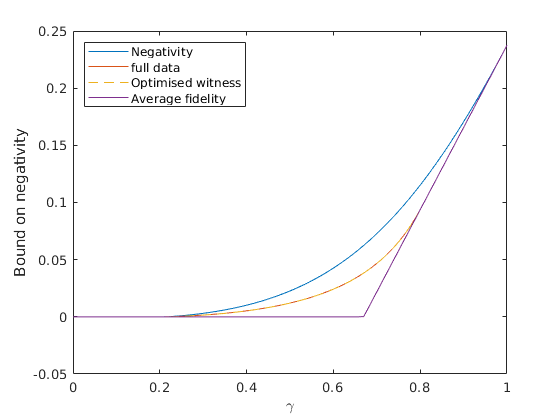

In [266]:
plot(gammav,Nv,gammav,TNv,gammav,TNWOv,'--',gammav,TNWAFv)
xlabel('$\gamma$','Interpreter','latex')
ylabel('Bound on negativity')
legend('Negativity','full data','Optimised witness','Average fidelity','Location','northwest')

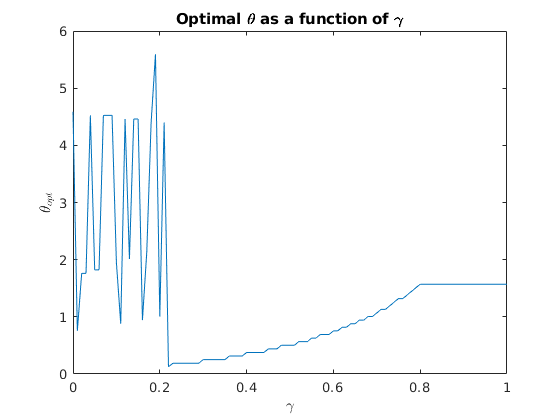

In [251]:
thetaoptv = zeros(1,npoints);

for i = 1:npoints
    [~,iopt] = max(TNWv(i,:));
    thetaoptv(i) = thetav(iopt);
end

plot(gammav,thetaoptv)
xlabel('$\gamma$','Interpreter','latex')
ylabel('$\theta_{opt}$','Interpreter','latex')
title('Optimal \theta as a function of \gamma')

- The regime $0 \leq \gamma \leq \approx 0.2$ is dominated by noise, since in this regime the violation is very small, and hence there must be numerical instability.
- Above this region, the optimal value of $\theta$ is seen to increase smoothly until around $\gamma \approx 0.8$.
- At $\gamma \approx 0.8$, the average fidelity becomes equally good to the optimised witness, and the optimal value of $\theta$ becomes constant in this regime too

### Check against Vidal bound:

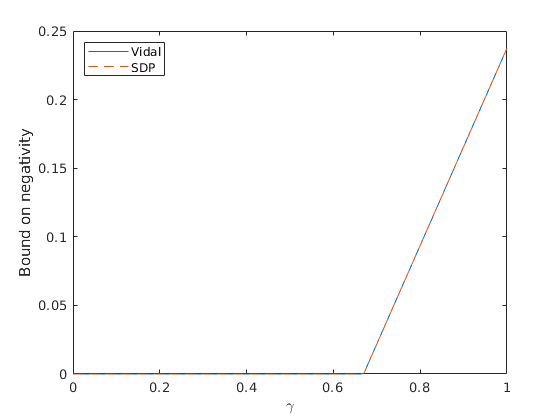

In [260]:
Nfv = zeros(1,npoints);

fax = zeros(2,2,oa,6);
for x = 1:ma
    fax(:,:,1,x) = 4/ma*omegax(:,:,x);
end

for i = 1:ngam

    gamma = gammav(i);
    rho = rhoexp(v,gamma,delta);
    sigma = genTeleportationData(rho,Ma,omegax);

    f = 0;
    for x = 1:ma
        for a = 1:oa
            f = f + trace(fax(:,:,a,x)*sigma(:,:,a,x));
        end
    end
    
    Nfv(i) = max(3/2*f - 1,0);
    
end

plot(gammav,Nfv,gammav,TNWAFv,'--')
xlabel('$\gamma$','Interpreter','latex')
ylabel('Bound on negativity')
legend('Vidal','SDP','Location','northwest')

As can be seen, the SDP reproduces the expression found by Vidal